Imports.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

Acquire data.

In [2]:
train_df = pd.read_csv("weather_route_data.csv", header=0)
train_df.columns.values

array(['start_time', 'end_time', 'temperature', 'humidity', 'wind_speed',
       'precipitation', 'route_length', 'average_speed',
       'ave_fuel_cons_per_100km', 'speedometer', 'season'], dtype=object)

I can't detect any more typos, errors or blank spaces in dataset, most of them were fixed in the previous steps.

In [3]:
train_df.tail()

,start_time,end_time,temperature,humidity,wind_speed,precipitation,route_length,average_speed,ave_fuel_cons_per_100km,speedometer,season
520,2023-04-11 03:58:17,11.04.2023 08:36:20,3.45,95.5,9.10,0.00,356.3,76.9,21.8,447067,1
521,2023-04-12 03:00:37,12.04.2023 07:05:35,7.80,87.0,17.30,0.40,347.3,85.1,20.7,447696,1
522,2023-04-13 10:16:52,13.04.2023 14:46:01,9.20,70.0,20.10,0.10,339.8,75.7,26.6,448572,1
523,2023-04-24 14:53:21,24.04.2023 16:11:04,14.60,55.0,22.95,0.05,107.3,82.8,26.6,450289,1
524,2023-04-25 05:31:47,25.04.2023 07:15:27,5.50,82.0,14.00,0.00,132.1,76.5,26.5,450421,1


In [4]:
train_df.info()
print("_" * 40)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   start_time               525 non-null    object 
 1   end_time                 525 non-null    object 
 2   temperature              525 non-null    float64
 3   humidity                 525 non-null    float64
 4   wind_speed               525 non-null    float64
 5   precipitation            525 non-null    float64
 6   route_length             525 non-null    float64
 7   average_speed            525 non-null    float64
 8   ave_fuel_cons_per_100km  525 non-null    float64
 9   speedometer              525 non-null    int64  
 10  season                   525 non-null    int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 45.2+ KB
________________________________________


timeseries based: 'start_time', 'end_time'
numerical: temperature, humidity, wind_speed, precipitation, route_length, average_speed, ave_fuel_cons_per_100km, speedometer
seven features are floats, one is an integer Six
there are two object features as well

In [5]:
train_df.describe()

,temperature,humidity,wind_speed,precipitation,route_length,average_speed,ave_fuel_cons_per_100km,speedometer,season
count,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000
mean,9.425048,76.368571,11.764000,0.072476,267.065905,76.421524,24.189143,286144.952381,2.504762
std,7.986726,15.396528,5.735272,0.189690,92.312534,9.399930,2.998590,84844.417796,1.153519
min,-18.850000,25.000000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.200000,65.000000,7.600000,0.000000,184.000000,71.600000,22.300000,213612.000000,1.000000
50%,8.700000,80.000000,10.400000,0.000000,285.600000,78.600000,24.000000,275411.000000,3.000000
75%,15.800000,89.500000,14.650000,0.050000,349.700000,83.500000,25.800000,359577.000000,4.000000
max,34.400000,99.500000,39.000000,1.700000,638.500000,88.600000,42.100000,450421.000000,4.000000


average temperature value confirms the data is correct
Most of the routes were driven with a speed of 88.6 km/h.
Most of the routes generated average fuel consumption at the level of 25.8l/100km.
We can see the route that have the speed, speedometer and average fuel cons equal 0, it must be an error row, but it is only one, so I have deleted it.
Precipitation values are mostly near to 0, so it may appear that it is not enough data to draw some conclusions.

Grouping data for preliminary analysis.

In [6]:
train_df["temperature_group"] = (train_df["temperature"] // 5) * 5
train_df["average_speed_group"] = (train_df["average_speed"] // 5) * 5
train_df["humidity_group"] = (train_df["humidity"] // 10) * 10
train_df["wind_speed_group"] = (train_df["wind_speed"] // 3) * 3
train_df["precipitation_group"] = (train_df["precipitation"] // 0.02) * 0.02
train_df["route_length_group"] = (train_df["route_length"] // 50) * 50
train_df["speedometer_group"] = (train_df["speedometer"] // 30000) * 30000

In [7]:
result_of_temp = (
    train_df[["temperature_group", "ave_fuel_cons_per_100km"]]
    .groupby(["temperature_group"], as_index=False)
    .mean()
    .sort_values(by="ave_fuel_cons_per_100km", ascending=False)
)


result_of_ave_speed = (
    train_df[["average_speed_group", "ave_fuel_cons_per_100km"]]
    .groupby(["average_speed_group"], as_index=False)
    .mean()
    .sort_values(by="ave_fuel_cons_per_100km", ascending=False)
)

result_of_humidity = (
    train_df[["humidity_group", "ave_fuel_cons_per_100km"]]
    .groupby(["humidity_group"], as_index=False)
    .mean()
    .sort_values(by="ave_fuel_cons_per_100km", ascending=False)
)


result_of_wind_speed = (
    train_df[["wind_speed_group", "ave_fuel_cons_per_100km"]]
    .groupby(["wind_speed_group"], as_index=False)
    .mean()
    .sort_values(by="ave_fuel_cons_per_100km", ascending=False)
)


# I think there is no connection in this data between fuel consumption and precipitation
result_of_precipitation = (
    train_df[["precipitation_group", "ave_fuel_cons_per_100km"]]
    .groupby(["precipitation_group"], as_index=False)
    .mean()
    .sort_values(by="ave_fuel_cons_per_100km", ascending=False)
)

result_of_route_length = (
    train_df[["route_length_group", "ave_fuel_cons_per_100km"]]
    .groupby(["route_length_group"], as_index=False)
    .mean()
    .sort_values(by="ave_fuel_cons_per_100km", ascending=False)
)


result_of_speedometer = (
    train_df[["speedometer_group", "ave_fuel_cons_per_100km"]]
    .groupby(["speedometer_group"], as_index=False)
    .mean()
    .sort_values(by="ave_fuel_cons_per_100km", ascending=False)
)


result_of_season = (
    train_df[["season", "ave_fuel_cons_per_100km"]]
    .groupby(["season"], as_index=False)
    .mean()
    .sort_values(by="ave_fuel_cons_per_100km", ascending=False)
)

In [8]:
result_of_wind_speed

,wind_speed_group,ave_fuel_cons_per_100km
9,27.0,27.350000
6,18.0,24.870588
4,12.0,24.767073
7,21.0,24.675000
5,15.0,24.394000
8,24.0,24.283333
2,6.0,23.834532
3,9.0,23.817460
1,3.0,23.795652
10,39.0,23.500000


In [9]:
result_of_temp

,temperature_group,ave_fuel_cons_per_100km
0,-20.0,27.300000
3,-5.0,24.962000
4,0.0,24.500000
5,5.0,24.459292
1,-15.0,24.150000
6,10.0,24.111224
2,-10.0,24.016667
7,15.0,23.864835
9,25.0,23.770000
8,20.0,22.610000


In [10]:
result_of_speedometer

,speedometer_group,ave_fuel_cons_per_100km
11,450000,26.550000
4,240000,25.062319
5,270000,25.000000
6,300000,24.755319
2,180000,24.464615
1,150000,24.450000
10,420000,24.410256
8,360000,23.847917
9,390000,23.563415
3,210000,23.113793


In [11]:
result_of_season

,season,ave_fuel_cons_per_100km
2,3,24.617600
3,4,24.497872
1,2,24.015385
0,1,23.648592


In [12]:
result_of_route_length

,route_length_group,ave_fuel_cons_per_100km
1,100.0,24.784146
5,300.0,24.612621
8,600.0,24.400000
3,200.0,24.347368
6,350.0,24.200000
7,400.0,24.140000
4,250.0,23.972619
2,150.0,23.314493
0,0.0,0.000000


I think there is no connection in this data between fuel consumption and precipitation. There is not enough data.

In [13]:
result_of_precipitation

,precipitation_group,ave_fuel_cons_per_100km
11,0.54,28.066667
16,0.94,27.900000
14,0.74,26.900000
21,1.68,26.400000
20,1.18,26.200000
13,0.68,26.150000
6,0.28,25.880000
2,0.10,24.495833
10,0.48,24.340000
0,0.00,24.232199


In [14]:
result_of_humidity

,humidity_group,ave_fuel_cons_per_100km
6,80.0,24.375887
5,70.0,24.276596
7,90.0,24.266929
2,40.0,24.150000
3,50.0,24.009434
4,60.0,23.855263
1,30.0,23.433333
0,20.0,22.400000


In [15]:
result_of_ave_speed

,average_speed_group,ave_fuel_cons_per_100km
3,45.0,28.566667
2,40.0,27.700000
4,50.0,27.400000
5,55.0,26.835294
1,35.0,26.500000
7,65.0,25.200000
6,60.0,24.540000
8,70.0,24.431579
9,75.0,23.999123
10,80.0,23.675000


I think that time of day may have some impact to average fuel consumption. The only idea I came up is to find median from start and end time ane classified it in such a way: 22 <= median_time < 8 - night, else day, but it would be easier to analyze data when day = 1, night = 0.

In [16]:
train_df["start_time"] = pd.to_datetime(
    train_df["start_time"], format="%Y-%m-%d %H:%M:%S"
)
train_df["end_time"] = pd.to_datetime(train_df["end_time"], format="%d.%m.%Y %H:%M:%S")
time_difference = train_df["end_time"] - train_df["start_time"]
train_df["day_time"] = train_df["start_time"] + (time_difference // 2)
train_df["day_time"] = train_df["day_time"].dt.hour
train_df["rush_hour"] = train_df["day_time"]
train_df["day_time"] = train_df["day_time"].between(8, 20)

train_df["rush_hour"] = train_df["rush_hour"].between(15, 17) + train_df["rush_hour"].between(7, 9)

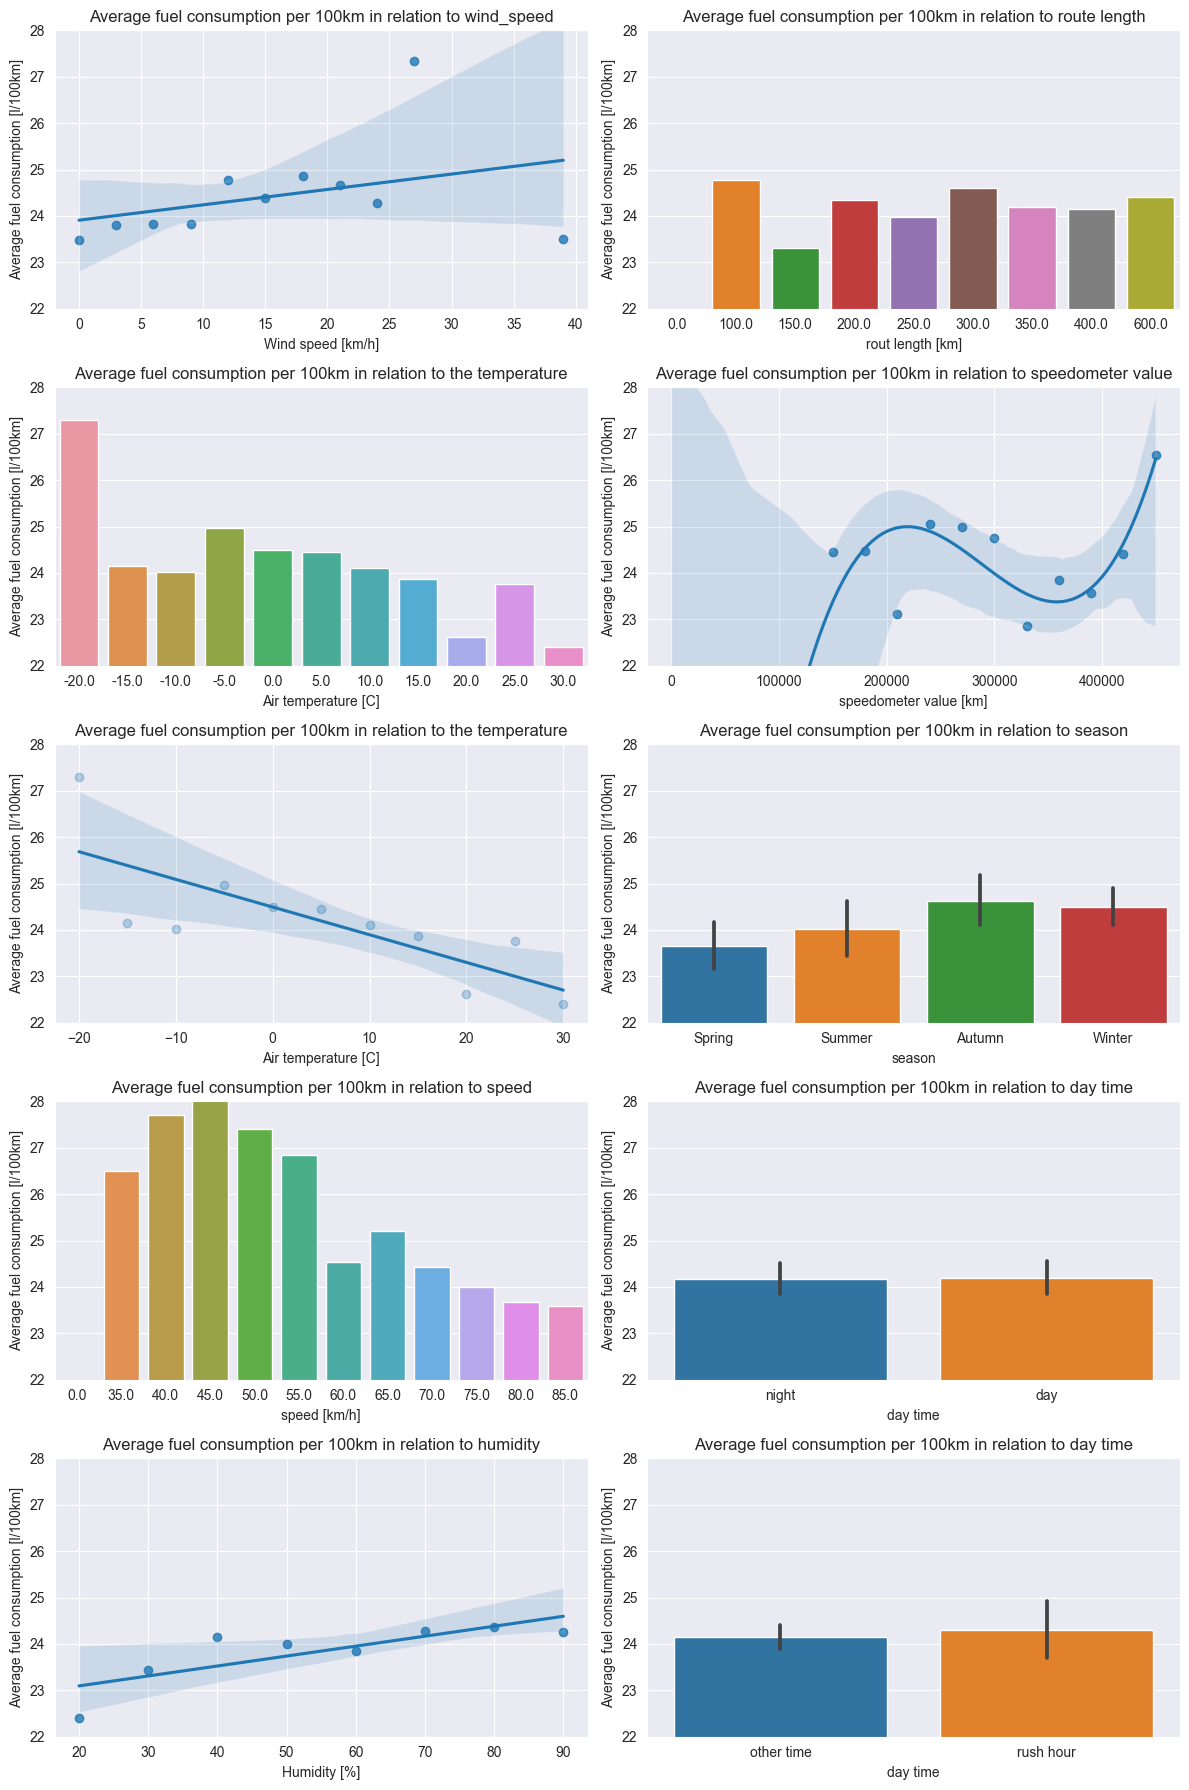

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 18))
sns.regplot(
    data=result_of_wind_speed,
    x=result_of_wind_speed["wind_speed_group"].values,
    y=result_of_wind_speed["ave_fuel_cons_per_100km"].values,
    ax=axes[0, 0],
)
axes[0, 0].set_ylim(22, 28)
axes[0, 0].set_xlabel("Wind speed [km/h]")
axes[0, 0].set_ylabel("Average fuel consumption [l/100km]")
axes[0, 0].set_title("Average fuel consumption per 100km in relation to wind_speed")

sns.barplot(
    x="temperature_group",
    y="ave_fuel_cons_per_100km",
    data=result_of_temp,
    ax=axes[1, 0],
)
axes[1, 0].set_ylim(22, 28)
axes[1, 0].set_xlabel("Air temperature [C]")
axes[1, 0].set_ylabel("Average fuel consumption [l/100km]")
axes[1, 0].set_title(
    "Average fuel consumption per 100km in relation to the temperature"
)

sns.regplot(
    x="temperature_group",
    y="ave_fuel_cons_per_100km",
    data=result_of_temp,
    scatter_kws={"alpha": 0.3},
    ax=axes[2, 0],
)
axes[2, 0].set_ylim(22, 28)
axes[2, 0].set_xlabel("Air temperature [C]")
axes[2, 0].set_ylabel("Average fuel consumption [l/100km]")
axes[2, 0].set_title(
    "Average fuel consumption per 100km in relation to the temperature"
)

sns.barplot(
    x="average_speed_group",
    y="ave_fuel_cons_per_100km",
    data=result_of_ave_speed,
    ax=axes[3, 0],
)
axes[3, 0].set_ylim(22, 28)
axes[3, 0].set_xlabel("speed [km/h]")
axes[3, 0].set_ylabel("Average fuel consumption [l/100km]")
axes[3, 0].set_title("Average fuel consumption per 100km in relation to speed")

sns.regplot(
    x="humidity_group",
    y="ave_fuel_cons_per_100km",
    data=result_of_humidity,
    ax=axes[4, 0],
)
axes[4, 0].set_ylim(22, 28)
axes[4, 0].set_xlabel("Humidity [%]")
axes[4, 0].set_ylabel("Average fuel consumption [l/100km]")
axes[4, 0].set_title("Average fuel consumption per 100km in relation to humidity")

sns.barplot(
    x="route_length_group",
    y="ave_fuel_cons_per_100km",
    data=result_of_route_length,
    ax=axes[0, 1],
)
axes[0, 1].set_ylim(22, 28)
axes[0, 1].set_xlabel("rout length [km]")
axes[0, 1].set_ylabel("Average fuel consumption [l/100km]")
axes[0, 1].set_title("Average fuel consumption per 100km in relation to route length")

sns.regplot(
    order=3,
    x="speedometer_group",
    y="ave_fuel_cons_per_100km",
    data=result_of_speedometer,
    ax=axes[1, 1],
)
axes[1, 1].set_ylim(22, 28)
axes[1, 1].set_xlabel("speedometer value [km]")
axes[1, 1].set_ylabel("Average fuel consumption [l/100km]")
axes[1, 1].set_title(
    "Average fuel consumption per 100km in relation to speedometer value"
)

sns.barplot(
    x="season",
    y="ave_fuel_cons_per_100km",
    data=train_df,
    ax=axes[2, 1],
)
axes[2, 1].set_xticklabels(["Spring", "Summer", "Autumn", "Winter"])
axes[2, 1].set_ylim(22, 28)
axes[2, 1].set_xlabel("season")
axes[2, 1].set_ylabel("Average fuel consumption [l/100km]")
axes[2, 1].set_title("Average fuel consumption per 100km in relation to season")

sns.barplot(
    x="day_time",
    y="ave_fuel_cons_per_100km",
    data=train_df,
    ax=axes[3, 1],
)
axes[3, 1].set_xticklabels(["night", "day"])
axes[3, 1].set_ylim(22, 28)
axes[3, 1].set_xlabel("day time")
axes[3, 1].set_ylabel("Average fuel consumption [l/100km]")
axes[3, 1].set_title("Average fuel consumption per 100km in relation to day time")

sns.barplot(
    x="rush_hour",
    y="ave_fuel_cons_per_100km",
    data=train_df,
    ax=axes[4, 1],
)
axes[4, 1].set_xticklabels(["other time", "rush hour"])
axes[4, 1].set_ylim(22, 28)
axes[4, 1].set_xlabel("day time")
axes[4, 1].set_ylabel("Average fuel consumption [l/100km]")
axes[4, 1].set_title("Average fuel consumption per 100km in relation to day time")

plt.tight_layout()
plt.show()

DROPPING DATA
start_time and end_time were only necessary when I was connecting tables into one,
and it helped to create 'season' column, but now it is redundant
speedometer - cannot see any connection with fuel consumption
rout length - cannot see any connection with fuel consumption
precipitation - this column is mostly filled with 0's, so it will not help
rush hour and day_time - it has to little correlation
I also dropped all grouped columns, as I want to have the exact data in model.

In [18]:
train_df.drop(
    [
        "start_time",
        "end_time",
        "day_time",
        "rush_hour",
        "speedometer",
        "route_length",
        "precipitation",
        "temperature_group",
        "average_speed_group",
        "humidity_group",
        "wind_speed_group",
        "precipitation_group",
        "route_length_group",
        "speedometer_group",
    ],
    axis=1,
    inplace=True
)

train_df.columns.values

array(['temperature', 'humidity', 'wind_speed', 'average_speed',
       'ave_fuel_cons_per_100km', 'season'], dtype=object)

In [19]:
X = train_df.drop("ave_fuel_cons_per_100km", axis=1)
Y = train_df["ave_fuel_cons_per_100km"]

Splitting data into train and test.

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

Correlation check

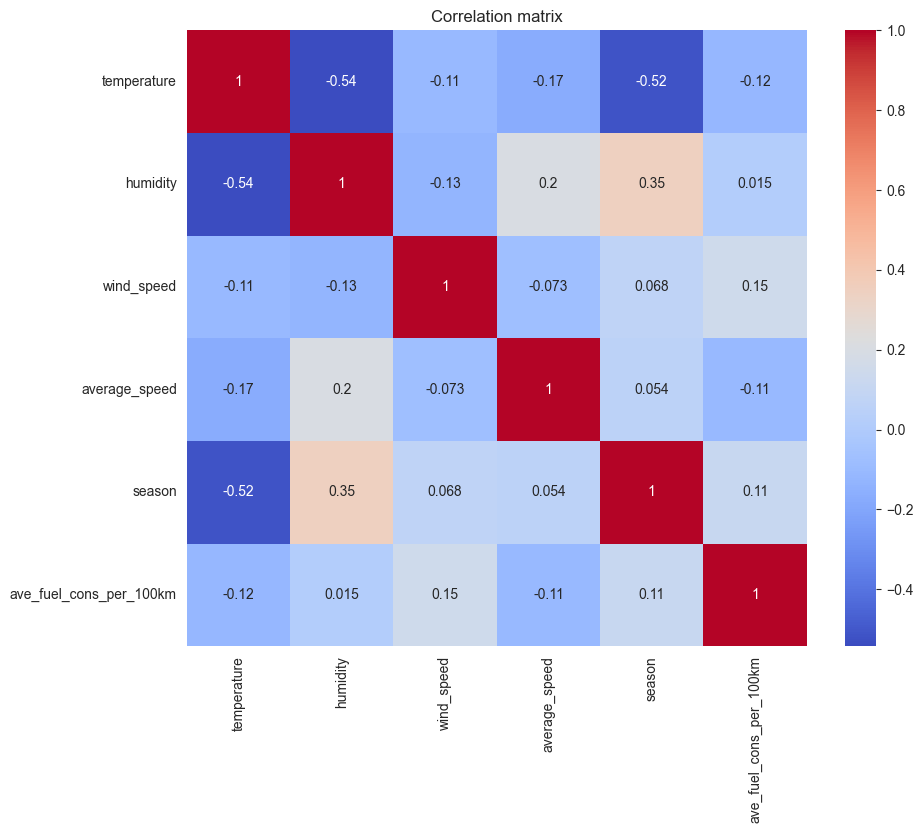

In [21]:
corr_matrix = pd.concat([X_train, Y_train], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()

Data scaling.

In [22]:
X_train.describe()

,temperature,humidity,wind_speed,average_speed,season
count,420.000000,420.000000,420.000000,420.000000,420.000000
mean,9.489524,76.124405,11.922500,76.247381,2.478571
std,7.865563,15.738527,5.911226,9.694073,1.158972
min,-12.050000,25.000000,1.100000,0.000000,1.000000
25%,3.200000,64.500000,7.550000,71.675000,1.000000
50%,9.000000,80.000000,10.600000,78.650000,2.500000
75%,15.800000,89.500000,15.112500,83.425000,4.000000
max,34.400000,99.500000,39.000000,88.600000,4.000000


In [23]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = MinMaxScaler()
Y_train_scaled = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
Y_test_scaled = y_scaler.transform(Y_test.values.reshape(-1, 1))

df_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_train_scaled['Y_train'] = Y_train_scaled.flatten()

corr_matrix = df_train_scaled.corr()
corr_matrix

,temperature,humidity,wind_speed,average_speed,season,Y_train
temperature,1.000000,-0.542919,-0.107520,-0.170578,-0.516520,-0.115742
humidity,-0.542919,1.000000,-0.129263,0.199529,0.347386,0.015096
wind_speed,-0.107520,-0.129263,1.000000,-0.073212,0.067593,0.147063
average_speed,-0.170578,0.199529,-0.073212,1.000000,0.054440,-0.108569
season,-0.516520,0.347386,0.067593,0.054440,1.000000,0.112233
Y_train,-0.115742,0.015096,0.147063,-0.108569,0.112233,1.000000


In [24]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, Y_train_scaled)
linreg_scores = np.mean(cross_val_score(linreg, X_train_scaled, Y_train_scaled, scoring='r2', cv=10))
Y_pred = linreg.predict(X_test_scaled)
mse = mean_squared_error(Y_test_scaled, Y_pred, squared=False)
print(linreg_scores, mse)

-0.028220286279838625 0.058139375067214116


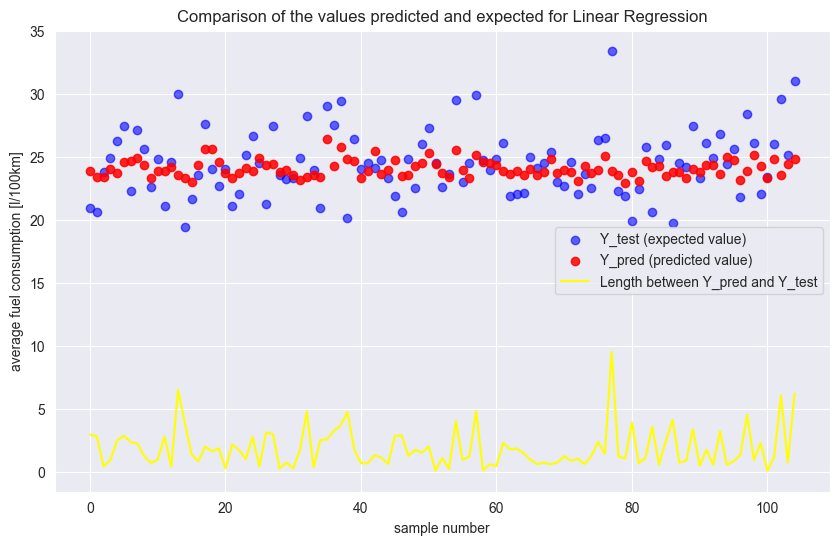

In [25]:
linreg.fit(X_train, Y_train)
Y_pred = linreg.predict(X_test)
distances = np.abs(Y_pred - Y_test)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Y_test (expected value)', alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, color='red', label='Y_pred (predicted value)', alpha=0.85)
plt.plot(range(len(distances)), distances, color='yellow', label='Length between Y_pred and Y_test')
plt.xlabel("sample number")
plt.ylabel("average fuel consumption [l/100km]")

plt.legend()
plt.title("Comparison of the values predicted and expected for Linear Regression")
plt.show()

In [26]:
svr = SVR()
svr.fit(X_train_scaled, Y_train_scaled.ravel())
svr_scores = np.mean(cross_val_score(svr, X_train_scaled, Y_train_scaled.ravel(), scoring='r2', cv=10))
Y_pred = svr.predict(X_test_scaled)
mse1 = mean_squared_error(Y_test_scaled.ravel(), Y_pred, squared=False)
print(mse1, svr_scores)

0.06154463877870959 -0.06250744562877905


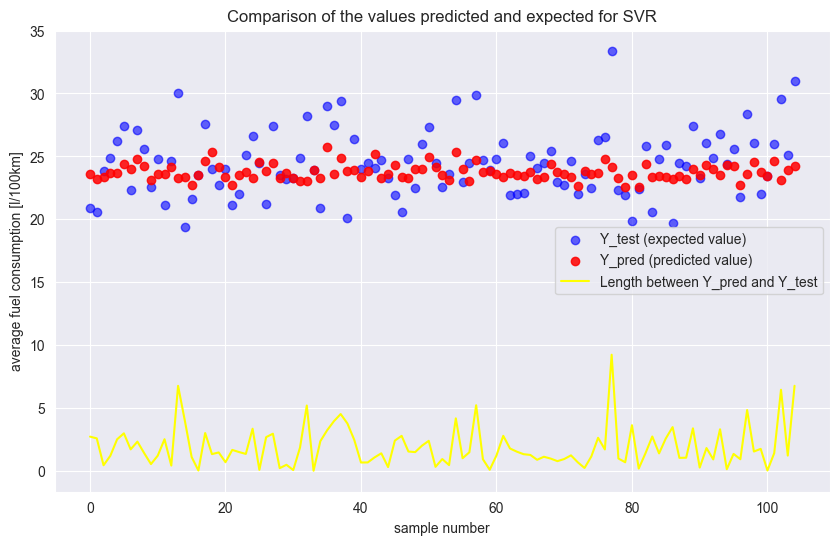

In [27]:
svr.fit(X_train, Y_train)
Y_pred = svr.predict(X_test)
distances = np.abs(Y_pred - Y_test)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Y_test (expected value)', alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, color='red', label='Y_pred (predicted value)', alpha=0.85)
plt.plot(range(len(distances)), distances, color='yellow', label='Length between Y_pred and Y_test')
plt.xlabel("sample number")
plt.ylabel("average fuel consumption [l/100km]")

plt.legend()
plt.title("Comparison of the values predicted and expected for SVR")
plt.show()

In [28]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5)
rfr.fit(X_train_scaled, Y_train_scaled.ravel())
rfr_score = np.mean(cross_val_score(rfr, X_train_scaled, Y_train_scaled.ravel(), scoring='r2', cv=10))
Y_pred = rfr.predict(X_test_scaled)
mse2 = mean_squared_error(Y_test_scaled.ravel(), Y_pred, squared=False)
print(mse2, rfr_score)

0.05873509016928937 -0.012315365815348788


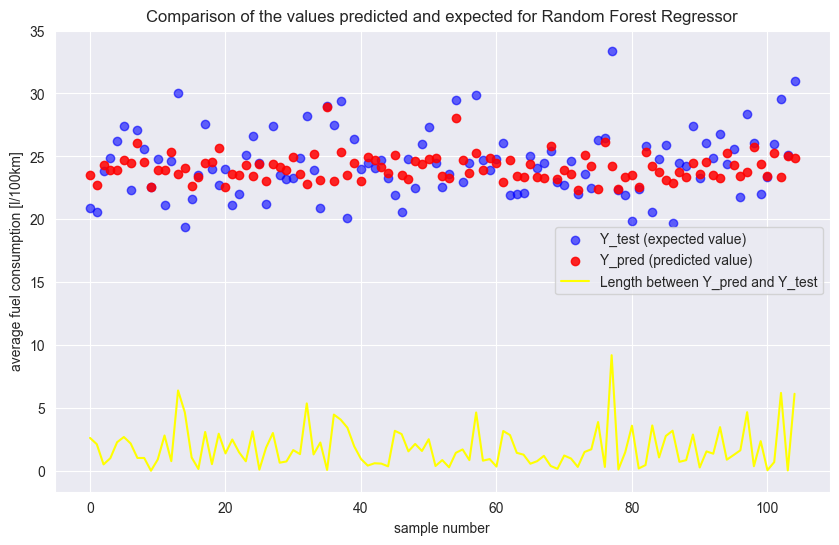

In [29]:
rfr.fit(X_train, Y_train)
Y_pred = rfr.predict(X_test)
distances = np.abs(Y_pred - Y_test)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Y_test (expected value)', alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, color='red', label='Y_pred (predicted value)', alpha=0.85)
plt.plot(range(len(distances)), distances, color='yellow', label='Length between Y_pred and Y_test')
plt.xlabel("sample number")
plt.ylabel("average fuel consumption [l/100km]")

plt.legend()
plt.title("Comparison of the values predicted and expected for Random Forest Regressor")
plt.show()

In [30]:
tree_model = DecisionTreeRegressor(max_depth=5, min_samples_split=5, max_features=3)
tree_model.fit(X_train_scaled, Y_train_scaled.ravel())
tree_score = np.mean(cross_val_score(tree_model, X_train_scaled, Y_train_scaled.ravel(), scoring='r2', cv=10))
Y_pred = tree_model.predict(X_test_scaled)
mse3 = mean_squared_error(Y_test_scaled.ravel(), Y_pred, squared=False)
print(mse3, tree_score)

0.06082797277078624 -0.13617818005353804


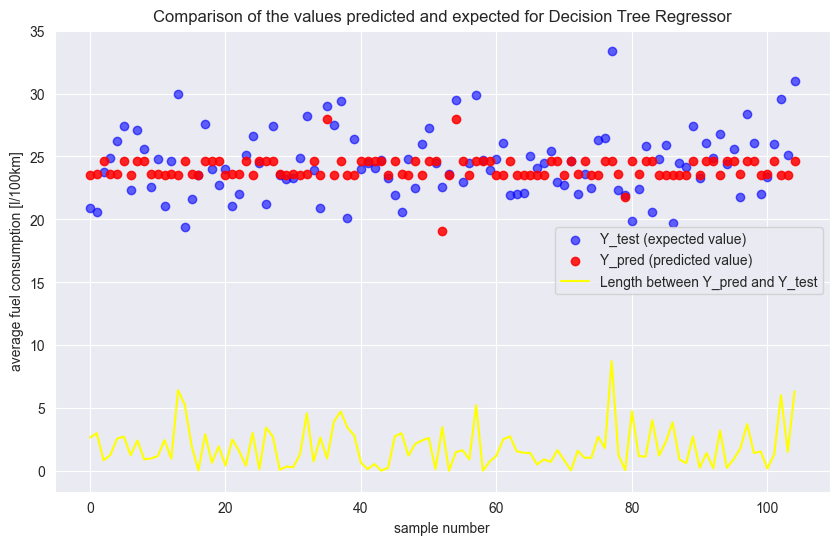

In [31]:
tree_model.fit(X_train, Y_train)
Y_pred = tree_model.predict(X_test)
distances = np.abs(Y_pred - Y_test)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Y_test (expected value)', alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, color='red', label='Y_pred (predicted value)', alpha=0.85)
plt.plot(range(len(distances)), distances, color='yellow', label='Length between Y_pred and Y_test')
plt.xlabel("sample number")
plt.ylabel("average fuel consumption [l/100km]")

plt.legend()
plt.title("Comparison of the values predicted and expected for Decision Tree Regressor")
plt.show()

In [32]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, Y_train_scaled.ravel())
ridge_score = np.mean(cross_val_score(ridge_model, X_train_scaled, Y_train_scaled.ravel(), scoring='r2', cv=10))
Y_pred = ridge_model.predict(X_test_scaled)
mse4 = mean_squared_error(Y_test_scaled, Y_pred, squared=False)
print(mse4, ridge_score)

0.05852416486147477 -0.017211252209429474


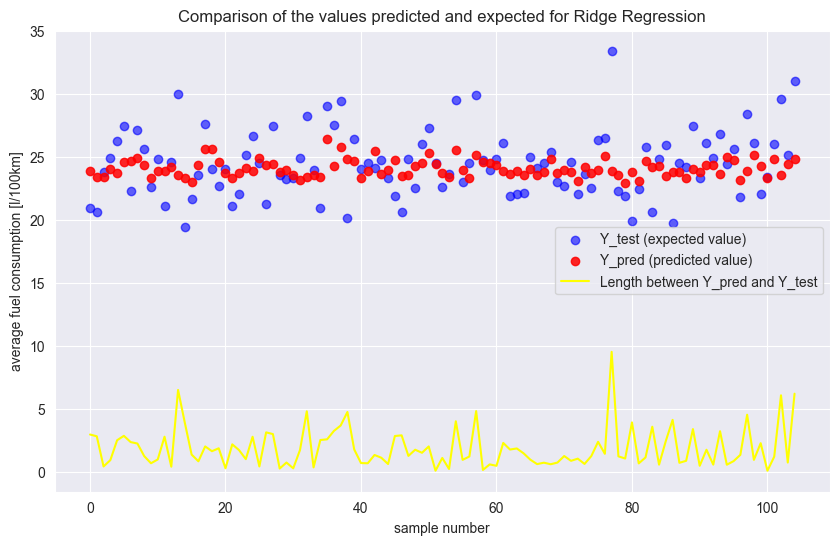

In [33]:
ridge_model.fit(X_train, Y_train)
Y_pred = ridge_model.predict(X_test)
distances = np.abs(Y_pred - Y_test)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Y_test (expected value)', alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, color='red', label='Y_pred (predicted value)', alpha=0.85)
plt.plot(range(len(distances)), distances, color='yellow', label='Length between Y_pred and Y_test')
plt.xlabel("sample number")
plt.ylabel("average fuel consumption [l/100km]")

plt.legend()
plt.title("Comparison of the values predicted and expected for Ridge Regression")
plt.show()

In [34]:
scores_results = {
    "Linear Regression": linreg_scores,
    "SVR": svr_scores,
    "Random Forest": rfr_score,
    "Decision Trees ": tree_score,
    "Ridge Regression ": ridge_score,
}

scores_results = pd.DataFrame.from_dict(scores_results, orient='index', columns=['Cross validation mean score'])
scores_results.index.name = 'Model'
scores_results

,Cross validation mean score
Model,
Linear Regression,-0.028220
SVR,-0.062507
Random Forest,-0.012315
Decision Trees,-0.136178
Ridge Regression,-0.017211


In [35]:
mse_results = {
    "Linear Regression": mse,
    "SVR": mse1,
    "Random Forest": mse2,
    "Decision Trees ": mse3,
    "Ridge Regression ": mse4,
}
errors_results = pd.DataFrame.from_dict(mse_results, orient='index', columns=['Mean squared errors score'])
errors_results.index.name = 'Model'
errors_results


,Mean squared errors score
Model,
Linear Regression,0.058139
SVR,0.061545
Random Forest,0.058735
Decision Trees,0.060828
Ridge Regression,0.058524


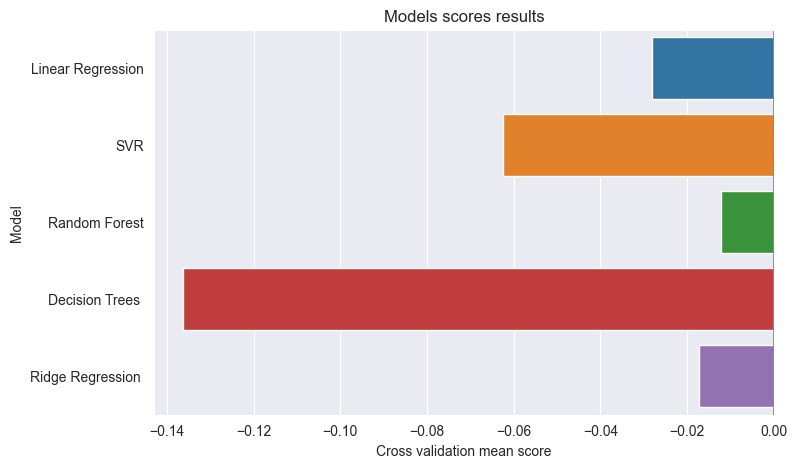

In [36]:
plt.figure(figsize=(8, 5))
models_accuracy = sns.barplot(x='Cross validation mean score', y=scores_results.index, data=scores_results, orient='h')
models_accuracy.axvline(0, color='gray', linewidth=2)
models_accuracy.set_title("Models scores results")
plt.show()

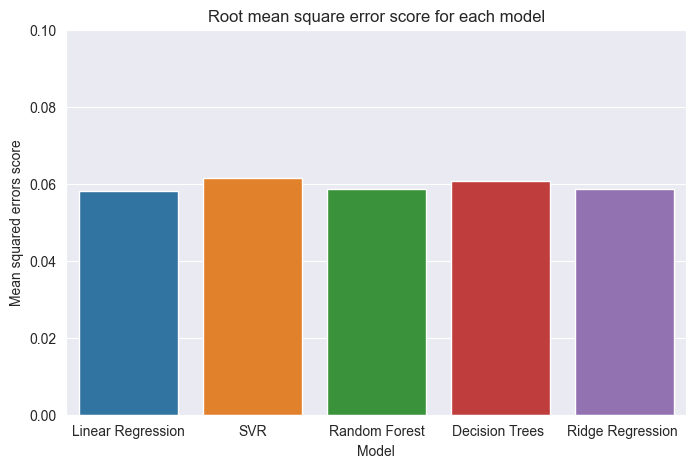

In [37]:
plt.figure(figsize=(8, 5))
models_mse = sns.barplot(x=errors_results.index, y='Mean squared errors score', data=errors_results)
models_mse.set_title("Root mean square error score for each model")
models_mse.set_ylim(0, 0.1)
plt.show()